# Solar Dynamo

In [1]:
using DifferentialEquations
using StochasticDelayDiffEq
using SpecialFunctions
using Plots
using XLSX
using Turing
using Distributions
using SimulatedAnnealingABC
using Distances
using DataFrames
using FFTW
using CairoMakie
using PairPlots

In [2]:
# EXTRACTING OPEN MAGNETIC FLUX AND SUNSPOT NUMBER RECORDS FROM XLSX FILE

df = DataFrame(
    year = Int[],
    open_magn_flux = Float64[],
    open_magn_flux_err = Float64[],
    ssa_open_magn_flux = Float64[],
    sunspots_num = Float64[],
    sunspots_err = Float64[],
    ssa_sunspots = Float64[]
)

# Apri il file e leggi i dati
XLSX.openxlsx("SN Usoskin Brehm.xlsx") do file
    sheet = file["Data"] 

    for row in XLSX.eachrow(sheet)
        if isa(row[2], Number)
            push!(df, (
                year = row[2],
                open_magn_flux = row[3],
                open_magn_flux_err = row[4],
                ssa_open_magn_flux = row[5],
                sunspots_num = row[7],
                sunspots_err = row[8],
                ssa_sunspots = row[9]
            ))
        end
    end
end


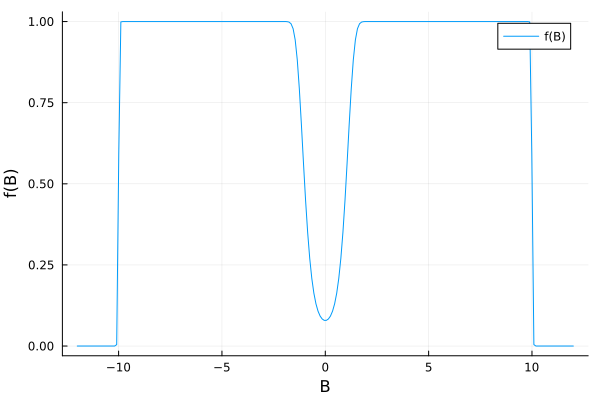

In [3]:
# BOX-SHAPED FUNCTION FOR THE MAGNETIC FIELD RANGE

# Define limits
B_min = 1
B_max = 10

# Define the function
function f(B)
    return 1 / 4 * (1 .+ erf.(B .^ 2 .- B_min ^ 2)) .* (1 .- erf.(B .^ 2 .- B_max ^ 2))
end

# Plot (range [-12, 12])
B_values = range(-12, stop = 12, length = 240)
f_values = f(B_values)
Plots.plot(B_values, f_values, xlabel = "B", ylabel = "f(B)", label = "f(B)")

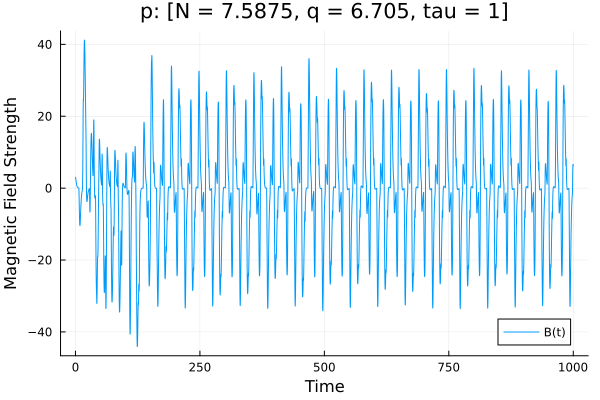

In [4]:
# DDE PROBLEM WITHOUT NOISE AND PERIODIC MODULATION

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, q, tau = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - q)[1] * f(h(p, t - q)[1]))
end

# Define parameters
N = 15
T0 = 0.52
T1 = 0.3
tau = 1
q = (T0 + T1) / tau
par = [N, q, tau]

# Define initial conditions
B0 = [3.0, 0.0]
tspan = (0, 100)
h(p, t) = [0.0, 0.0]

# Define and solve the DDE problem
prob = DDEProblem(MagneticField, B0, h, tspan, par)
sol = solve(prob, MethodOfSteps(Tsit5()), saveat = 0.01)

# Plot 
Plots.plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, q = $q, tau = $tau]", linewidth = 1)

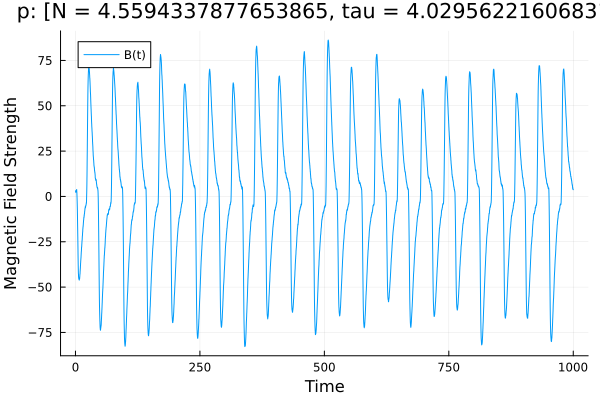

In [5]:
# SDDE PROBLEM WITHOUT PERIODIC MODULATION

# Define parameters
N = 4.5594337877653865
T0 = 0.52
T1 = 0.3
tau = 4.029562216068315
q = (T0 + T1) / tau
sigma = 0.10354986294770369
T = 9.176796014373267
B_max = 6.036375264367653
params = [N, T, tau, sigma, B_max]

# Define initial conditions
B0 = [3, 0]
tspan = (0, 1000)
h(p, t) = [0.0, 0.0]

# Define noise initial conditions
noise0 = [1.0]

# Define the function for the DDE
function MagneticField(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p

  B = u[1]
  dB = u[2]

  du[1] = dB
  du[2] = - ((2 / tau) * dB + (B / tau^2) + N * h(p, t - (T / tau))[1] * f(h(p, t - (T / tau))[1]))
end

function noise(du, u, h, p, t)
  N, T, tau, sigma, Bmax = p
  du[1] = (sigma * Bmax)
end

# Define and solve the SDDE problem
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, params)
sol = solve(prob, EM(), dt = 0.01)

# Plot 
Plots.plot(sol.t, sol[1, :], label = "B(t)", xlabel = "Time", ylabel = "Magnetic Field Strength", title = "p: [N = $N, tau = $tau]", linewidth = 1)
#plot!(sol.t, sol[2, :], label="dB/dt", linewidth=1)
#plot!(sol.t, sol[3, :], label="d^2B/dt^2", linewidth=1)

In [7]:
# ANALYSIS WITH SYNTETIC DATA
p = [6.2, 3.1, 3.5, 0.04, 6.0]  # Parameters N, T, tau, sigma, Bmax
tspan = (0.0, 500.0)

# Create a DDEProblem object
prob = SDDEProblem(MagneticField, noise, B0, h, tspan, p)
# Solve the DDE using a suitable method
sol = solve(prob, EM(), dt = 0.01)
# Generate observational data
observed_data = sol[1, :]  # Add noise
fourier_transform_obs = fft(observed_data)
fourier_range_obs = 1:6:120
fourier_obs = abs.(fourier_transform_obs[fourier_range_obs])

# Define prior distributions for the parameters
prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

# Define a function to simulate data and calculate distance
function f_dist(x::Vector{Float64}; type::Int64 = 1)
    sol = solve(SDDEProblem(MagneticField, noise, B0, h, tspan, x), EM(), dt = 0.01)
    simulated_data = sol[1, :]

    # Perform Fourier transform
    fourier_transform = fft(simulated_data)
    fourier_range = 1:6:120
    fourier_stats = abs.(fourier_transform[fourier_range])

    rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
    
    return rho
end

# Run the ABC with Simulated Annealing
result = sabc(f_dist, prior, n_particles=1000, n_simulation=5000000, v=1.0, type=1)
println("Estimated parameters: ", result)

┌ Info: Using threads: 4 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:192
┌ Info: Set BLAS threads = 1 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:195
┌ Info: Initializing population...
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:219
┌ Info: Initial resampling (δ = 0.1) - ESS = 812.0508822578979 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:258
┌ Info: Population with 1000 particles initialised.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:280
┌ Info: Initial ϵ = [1.0452283850945845, 0.8967445758522232, 1.3398518922661862, 2.244217788775829, 0.9130086442547938, 0.9543641163768573, 0.9661522397231812, 2.1486273259362076, 1.036830787983196, 0.86

Estimated parameters: Approximate posterior sample with 1000 particles:
  - simulations used: 5000000
  - average transformed distance: 0.1833
  - ϵ: [0.1743, 0.09908, 0.1253, 0.1932, 0.1225, 0.09165, 0.1633, 0.1471, 0.1454, 0.1519, 0.1203, 0.1922, 0.1627, 0.08168, 0.1604, 0.1473, 0.194, 0.09489, 0.1535, 0.1506]
  - population resampling: 9
  - acceptance rate: 0.003733
The sample can be accessed with the field `population`.
The history of ϵ can be accessed with the field `state.ϵ_history`.
 -------------------------------------- 



┌ Info: 2024-05-24T09:16:32.054  All particles have been updated 4999 times.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:506


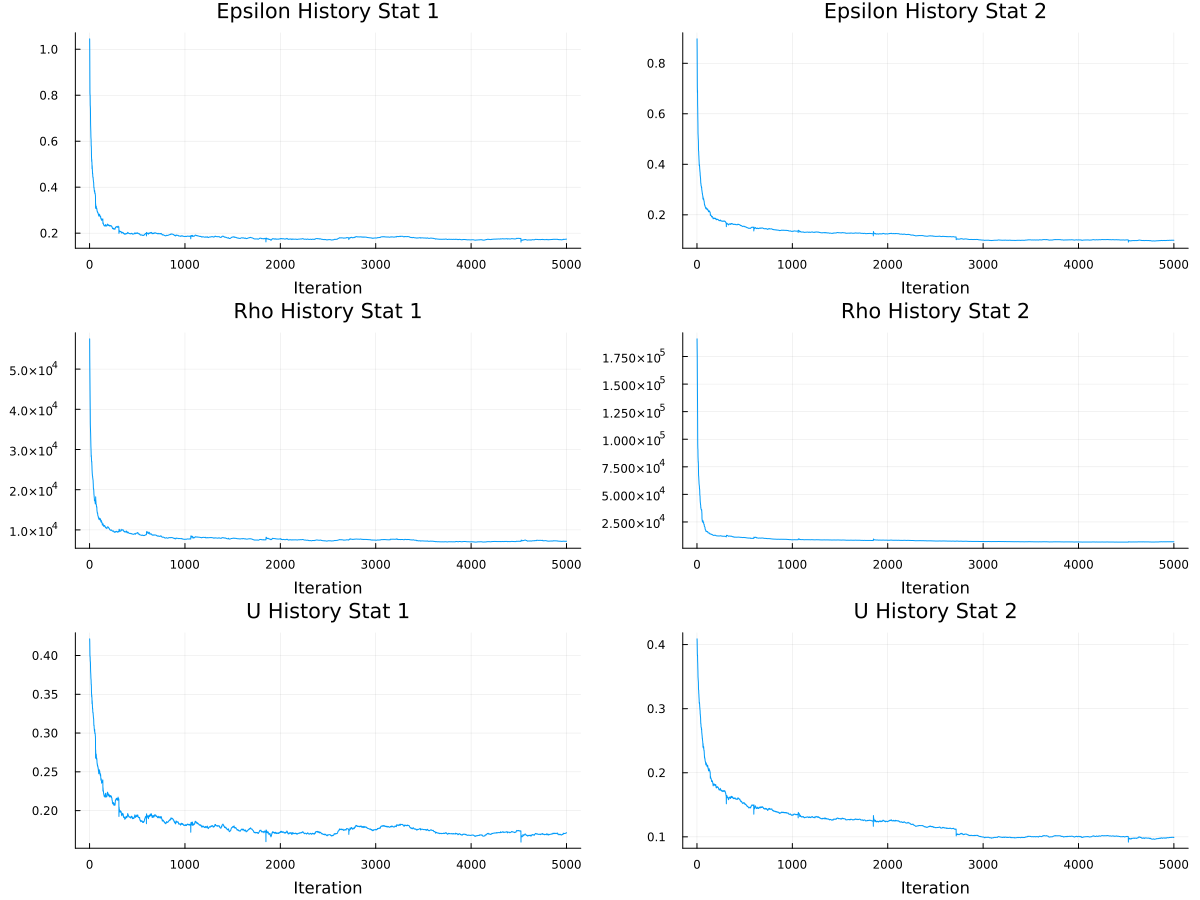

In [8]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = Plots.plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = Plots.plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = Plots.plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = Plots.plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = Plots.plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = Plots.plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = Plots.plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [9]:
# Extract parameter samples for each parameter
pop_history = vec(pop_singeps)
param_samples = reshape(pop_history, 5, 1000)

println("Value of N:")
N_value = param_samples[1,951:1000]
N = mean(N_value)
println(N)


println("\nValue of T:")
T_value = param_samples[2,951:1000]
T = mean(T_value)
println(T)

println("\nValue of tau:")
tau_value = param_samples[3,951:1000]
tau = mean(tau_value)
println(tau)

println("\nValue of sigma:")
sigma_value = param_samples[4,951:1000]
sigma = mean(sigma_value)
println(sigma)

println("\nValue of Bmax:")
Bmax_value = param_samples[5,951:1000]
Bmax = mean(Bmax_value)
println(Bmax)

Value of N:
4.280910725640207

Value of T:
5.401623260428908

Value of tau:
3.5300507358340294

Value of sigma:
0.09296600406234834

Value of Bmax:
4.5327589343442405


In [10]:
posterior_params = DataFrame(;N_value, T_value, tau_value, sigma_value, Bmax_value)

pairplot(
    posterior_params,
    PairPlots.Truth(
        (;
            N_value = 6.2,
            T_value = 3.1,
            tau_value = 3.5,
            sigma_value = 0.04,
            Bmax_value = 6.0
        ),
        label="Mean Values"
    )
) 

ErrorException: No backend available!
Make sure to also `import/using` a backend (GLMakie, CairoMakie, WGLMakie).

If you imported GLMakie, it may have not built correctly.
In that case, try `]build GLMakie` and watch out for any warnings.


In [11]:
# ANALYSIS WITH REAL DATA
observed_data = df.sunspots_num
fourier_transform_obs = fft(observed_data)
fourier_range_obs = 1:6:120
fourier_obs = abs.(fourier_transform_obs[fourier_range_obs])

# Define prior distributions for the parameters
prior = product_distribution(Uniform(1, 15), Uniform(0.1, 15.0), Uniform(0.1, 6.0), Uniform(0.01, 0.3), Uniform(1, 15))

# Define a function to simulate data and calculate distance
function f_dist(x::Vector{Float64}; type::Int64 = 1)
    sol = solve(SDDEProblem(MagneticField, noise, B0, h, tspan, x), EM(), dt = 0.01)
    simulated_data = sol[1, :]

    # Perform Fourier transform
    fourier_transform = fft(simulated_data)
    fourier_range = 1:6:120
    fourier_stats = abs.(fourier_transform[fourier_range])

    rho = [euclidean(fourier_stats[i], fourier_obs[i]) for i in 1:length(fourier_stats)]
    
    return rho
end

# Run the ABC with Simulated Annealing
result1 = sabc(f_dist, prior, n_particles=1000, n_simulation=1000000, v=1.0, type=1)
println("Estimated parameters: ", result1)

┌ Info: Using threads: 4 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:192
┌ Info: Set BLAS threads = 1 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:195
┌ Info: Initializing population...
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:219
┌ Info: Initial resampling (δ = 0.1) - ESS = 636.7653797146909 
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:258
┌ Info: Population with 1000 particles initialised.
└ @ SimulatedAnnealingABC C:\Users\lucre\.julia\packages\SimulatedAnnealingABC\LT2t8\src\SimulatedAnnealingABC.jl:280
┌ Info: Initial ϵ = [1014.2548852932695, 0.4890232928392801, 0.5466639908510651, 0.48386425501427194, 0.4785903365272418, 0.49440411508414245, 0.5117415738596623, 0.5237297700390002, 0.4875660258790477, 

In [ ]:
## Extract posterior population, trajectories for epsilon, rho and u
pop_singeps = hcat(result.population...)
eps_singeps = hcat(result.state.ϵ_history...)
rho_singeps = hcat(result.state.ρ_history...)
u_singeps = hcat(result.state.u_history...)

rho_stat1 = rho_singeps[1, :]
rho_stat2 = rho_singeps[2, :]

eps_stat1 = eps_singeps[1, :]
eps_stat2 = eps_singeps[2, :]

u_stat1 = u_singeps[1, :]
u_stat2 = u_singeps[2, :]

p1 = Plots.plot(eps_stat1, title="Epsilon History Stat 1", xlabel="Iteration", legend=false)
p2 = Plots.plot(eps_stat2, title="Epsilon History Stat 2", xlabel="Iteration", legend=false)
p3 = Plots.plot(rho_stat1, title="Rho History Stat 1", xlabel="Iteration", legend=false)
p4 = Plots.plot(rho_stat2, title="Rho History Stat 2", xlabel="Iteration", legend=false)
p5 = Plots.plot(u_stat1, title="U History Stat 1", xlabel="Iteration", legend=false)
p6 = Plots.plot(u_stat2, title="U History Stat 2", xlabel="Iteration", legend=false)

# Combine plots
combined_plot = Plots.plot(p1, p2, p3, p4, p5, p6, layout=(3, 2), size=(1200, 900))

display(combined_plot)

In [ ]:
# Extract parameter samples for each parameter
pop_history = vec(pop_singeps)
param_samples = reshape(pop_history, 5, 1000)

println("Value of N:")
N_value = param_samples[1,951:1000]
N = mean(N_value)
println(N)


println("\nValue of T:")
T_value = param_samples[2,951:1000]
T = mean(T_value)
println(T)

println("\nValue of tau:")
tau_value = param_samples[3,951:1000]
tau = mean(tau_value)
println(tau)

println("\nValue of sigma:")
sigma_value = param_samples[4,951:1000]
sigma = mean(sigma_value)
println(sigma)

println("\nValue of Bmax:")
Bmax_value = param_samples[5,951:1000]
Bmax = mean(Bmax_value)
println(Bmax)

In [ ]:
posterior_params = DataFrame(;N_value, T_value, tau_value, sigma_value, Bmax_value)

pairplot(
    posterior_params,
    PairPlots.Truth(
        (;
            N_value = 6.2,
            T_value = 3.1,
            tau_value = 3.5,
            sigma_value = 0.04,
            Bmax_value = 6.0
        ),
        label="Mean Values"
    )
) 